**CSI 5139 Assignment 2**

This assignment explores the Keras API with tensorﬂow backend. We will use the Extended Outex texture dataset from the University of Oulu and LAGISFRE CNRS. We will train CNN architectures such as MLP, LeNet-5 and VGG-16 for multi texture classification. We will conclude with an attempted t-SNE visualization of the input training images.

# Setup

In [25]:
import os
from shutil import copy

#import tensorflow
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, MaxPooling2D, Conv2D
from keras.optimizers import RMSprop, Adagrad, Adam, SGD
from keras.applications import VGG16
from keras.models import load_model

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix

from pprint import pprint

# 1.1 Getting started

In [49]:
def generateData(file, path, dst):
    with open(file, "r", encoding='utf-8') as f:
        data = f.readlines()
    
    data = data[1:]
    data = [a.split(" ") for a in data]
    data = [[os.path.join(path, a[0]), a[1].split("\n")[0]] for a in data]
    
    for a in data:
        src = a[0]
        cat = a[1]
        new_dst = os.path.join(dst,cat)
        
        # check if directory exists
        if os.path.isdir(new_dst):
            pass
        else:        
            # make diretory
            os.mkdir(new_dst)
            
        #print(new_dst)
        copy(src, new_dst)

Use the test images for training and train images for testing.

In [ ]:
generateData("./Outex_TC_00030.tar/Outex-TC-00030/000/train.txt", "./Outex_TC_00030.tar/Outex-TC-00030/images/", "C:/Users/Sophie/Documents/GitHub/CSI5139/csi5139_a2/Outex-TC-00030/test/")
generateData("./Outex_TC_00030.tar/Outex-TC-00030/000/test.txt", "./Outex_TC_00030.tar/Outex-TC-00030/images/", "C:/Users/Sophie/Documents/GitHub/CSI5139/csi5139_a2/Outex-TC-00030/train/")

# 1.2 Perceptron

#### Flow from directory

In [76]:
#image size of 32×32

datagen = ImageDataGenerator()

train_batchsize = 32 # 160 images per 68 classes
test_batchsize = 4 # 20 images per 68 classes

train_generator = datagen.flow_from_directory(
    directory=r"./Outex-TC-00030/train/",
    target_size=(32, 32),
    color_mode="rgb",
    batch_size=train_batchsize,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_generator = datagen.flow_from_directory(
    directory=r"./Outex-TC-00030/test/",
    target_size=(32, 32),
    color_mode="rgb",
    batch_size=test_batchsize,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

print("Train generator length: ", len(train_generator))
print("Test generator length: ", len(test_generator))
print("Target size: ", train_generator.target_size)
#print("Generator indices: ", train_generator.class_indices)
#print("Generator filenames:", train_generator.filenames[:10])

Found 10880 images belonging to 68 classes.
Found 1360 images belonging to 68 classes.
Train generator length:  340
Test generator length:  340
Target size:  (32, 32)


#### Model

In [16]:
# Reference architecture from
# https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py

def perceptron():
    model = Sequential()
    model.add(Flatten(input_shape=(32, 32, 3)))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(68, activation='softmax'))
    return model

#### Run model

In [20]:
epochs = 50

model = perceptron()
model.summary()
rmsprop = RMSprop(lr=0.000001)
model.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

hist_mlp = model.fit_generator(
        train_generator,
        steps_per_epoch=(train_generator.samples/train_generator.batch_size),
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=(test_generator.samples/test_generator.batch_size),
        verbose=1,)

# Save the model
model.save('./runs/mlp_512-512_50.h5')
del model  # deletes the existing model

hist_mlp = hist_mlp.history

# save history
with open('./runs/mlp_512-512_50.hist', 'w', encoding="utf-8") as fout:
    pprint(hist_mlp, fout)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               1573376   
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 68)                34884     
Total params: 1,870,916
Trainable params: 1,870,916
Non-trainable params: 0
_________________________________________________________________


#### Loss curve of training and testing results

In [62]:
def plotLoss(train, test):
    iterations = list(range(len(train)))
    plt.plot(iterations, train, label="train")
    plt.plot(iterations, test, label="test")       

    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.grid(True, linestyle='dotted')
    plt.legend() #loc="upper left"

    plt.show()

In [61]:
# read history from file
with open('./runs/mlp_512-512_50.hist', 'r', encoding="utf-8") as fin:
    hist_mlp = eval(fin.read())

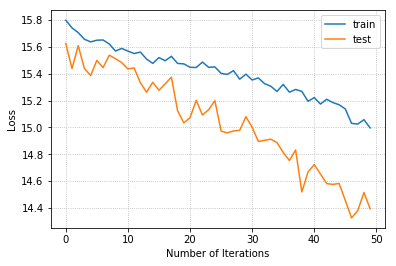

In [63]:
plotLoss(hist_mlp['loss'], hist_mlp['val_loss'])

# 1.3 LeNet-5

#### Flow from directory

In [181]:
#full size images

datagen = ImageDataGenerator()

train_batchsize = 32 # 160 images per 68 classes
test_batchsize = 4 # 20 images per 68 classes

train_generator_full = datagen.flow_from_directory(
    directory=r"./Outex-TC-00030/train/",
    #target_size=(32, 32),
    color_mode="rgb",
    batch_size=train_batchsize,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_generator_full = datagen.flow_from_directory(
    directory=r"./Outex-TC-00030/test/",
    #target_size=(32, 32),
    color_mode="rgb",
    batch_size=test_batchsize,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

print("Train generator length: ", len(train_generator_full))
print("Test generator length: ", len(test_generator_full))
print("Target size: ", train_generator_full.target_size)
#print("Generator indices: ", train_generator_full.class_indices)
#print("Generator filenames:", train_generator_full.filenames[:10])

Found 10880 images belonging to 68 classes.
Found 1360 images belonging to 68 classes.
Train generator length:  340
Test generator length:  340
Target size:  (256, 256)


#### Model

In [58]:
# Reference architecture from
# https://github.com/TaavishThaman/LeNet-5-with-Keras/blob/master/lenet_5.py

def lenet5_adapt():
    model = Sequential()
    model.add(Conv2D(filters = 6, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (256,256,3)))
    model.add(MaxPooling2D(pool_size = 2, strides = 2))
    model.add(Conv2D(filters = 16, kernel_size = 3, strides = 1, activation = 'relu', input_shape = (126,126,6)))
    model.add(MaxPooling2D(pool_size = 2, strides = 2))
    model.add(Flatten())
    model.add(Dense(units = 512, activation = 'relu'))
    model.add(Dense(units = 512, activation = 'relu'))
    model.add(Dense(units = 68, activation = 'softmax'))
    return model

#### Run model

In [64]:
epochs = 10

model = lenet5_adapt()
model.summary()
rmsprop = RMSprop(lr=0.000001)
model.compile(optimizer = rmsprop, loss = 'categorical_crossentropy', metrics = ['accuracy'])

hist_lenet5 = model.fit_generator(
        train_generator_full,
        steps_per_epoch=(train_generator_full.samples/train_generator_full.batch_size),
        epochs=epochs,
        validation_data=test_generator_full,
        validation_steps=(test_generator_full.samples/test_generator_full.batch_size),
        verbose=1,)

# Save the model
model.save('./runs/lenet-5-adapt.h5')
del model  # deletes the existing model

hist_lenet5 = hist_lenet5.history

# save history
with open('./runs/lenet-5-adapt.hist', 'w', encoding="utf-8") as fout:
    pprint(hist_lenet5, fout)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 252, 252, 6)       456       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 126, 126, 6)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 124, 124, 16)      880       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 61504)             0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)               31490560  
_________________________________________________________________
dense_38 (Dense)             (None, 512)               262656    
__________

#### Loss curve of training and testing results

In [68]:
# read history from file
with open('./runs/lenet-5-adapt.hist', 'r', encoding="utf-8") as fin:
    hist_lenet5 = eval(fin.read())

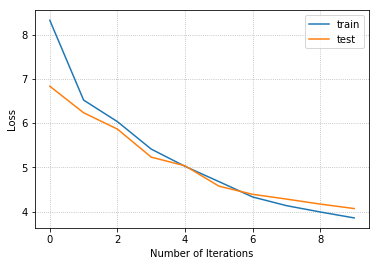

In [69]:
plotLoss(hist_lenet5['loss'], hist_lenet5['val_loss'])

# 1.5 Visualization with TSNE

In [187]:
# Reference from
# http://alexanderfabisch.github.io/t-sne-in-scikit-learn.html

In [186]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [150]:
datagen = ImageDataGenerator()

iter_gen = datagen.flow_from_directory(
    directory=r"./Outex-TC-00030/train/",
    target_size=(32, 32),
    color_mode="grayscale",
    batch_size=10880,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

print("Train generator length: ", len(iter_gen))
print("Target size: ", iter_gen.target_size)

Found 10880 images belonging to 68 classes.
Train generator length:  1
Target size:  (32, 32)


In [194]:
X, y = iter_gen.next()
X = X.reshape(X.shape[0],-1)
print(X.shape)
print(y.shape)

(10880, 1024)
(10880, 68)


In [195]:
labels = iter_gen.class_indices
labels = dict((v,k) for k,v in labels.items())
y_ind = np.argmax(y, axis=1)
y_label = np.array([labels[k] for k in y_ind])
print(y_label.shape)

(10880,)


In [196]:
X = X / 255.0

# Reduce to first 50 dimensions
X_pca = PCA(n_components=50).fit_transform(X)
X_train = X_pca
y_train = y_label

In [198]:
print(X_train.shape)
print(y_train.shape)
print(y_train[0])

(10880, 50)
(10880,)
8


In [204]:
# Plotting function
matplotlib.rc('font', **{'family' : 'sans-serif',
                         'weight' : 'bold',
                         'size'   : 18})
matplotlib.rc('text', **{'usetex' : True})

def plot_mnist(X, y, X_embedded, name, min_dist=10.0):
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(frameon=False)
    plt.title("\\textbf{Textures dataset} -- Two-dimensional "
          "embedding of 10,880 textured images with %s" % name)
    plt.setp(ax, xticks=(), yticks=())
    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                    wspace=0.0, hspace=0.0)

    sc = plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
            c=y, marker="x")
    plt.colorbar(sc)
    if min_dist is not None:
        from matplotlib import offsetbox
        shown_images = np.array([[15., 15.]])
        indices = list(range(X_embedded.shape[0]))
        #random.shuffle(indices)
        for i in indices:
            dist = np.sum((X_embedded[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist:
                continue
            shown_images = np.r_[shown_images, [X_embedded[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(X[i].reshape(32, 32), cmap=plt.cm.gray_r), X_embedded[i])
            ax.add_artist(imagebox)
    
    #plt.legend()
    plt.show()

In [202]:
X_train_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_train)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10880 samples in 0.062s...
[t-SNE] Computed neighbors for 10880 samples in 3.952s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10880
[t-SNE] Computed conditional probabilities for sample 2000 / 10880
[t-SNE] Computed conditional probabilities for sample 3000 / 10880
[t-SNE] Computed conditional probabilities for sample 4000 / 10880
[t-SNE] Computed conditional probabilities for sample 5000 / 10880
[t-SNE] Computed conditional probabilities for sample 6000 / 10880
[t-SNE] Computed conditional probabilities for sample 7000 / 10880
[t-SNE] Computed conditional probabilities for sample 8000 / 10880
[t-SNE] Computed conditional probabilities for sample 9000 / 10880
[t-SNE] Computed conditional probabilities for sample 10000 / 10880
[t-SNE] Computed conditional probabilities for sample 10880 / 10880
[t-SNE] Mean sigma: 0.121737
[t-SNE] Computed conditional probabilities in 0.746s
[t-SNE] Iteration 50: error = 90.39

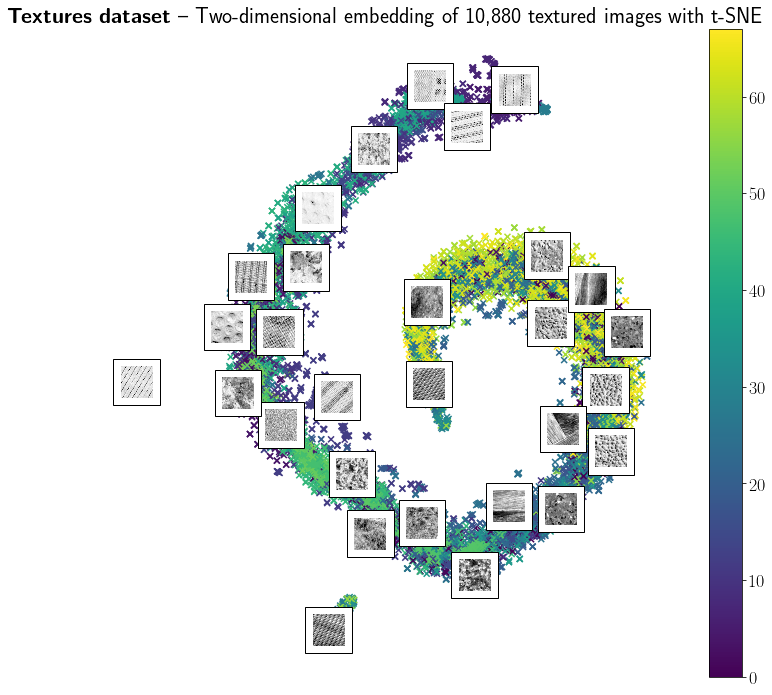

In [207]:
plot_mnist(X, y_train, X_train_embedded,
           "t-SNE", min_dist=150.0)

t-SNE is a method for embedding high-dimensional vectors in a low-dimensional space while preserving the pairwise distances of the points. The t-SNE method can help us to decide whether classes are separable in some linear or nonlinear representation. For high-dimensional data it is helpful to first reduce the dimensions to 50 dimensions with PCA and then perform t-SNE, since t-SNE is computationally intensive. 

The graph produced above shows the t-SNE plot in 2-dimensions of the texture dataset input images of 68 classes. The images were reduced to 32x32 dimensions in grayscale, which become 1024-dimensional vectors, and we can plug these into t-SNE and get 2-dimensional vectors for each image. We can then create a scatterplot of the first and second components of the vector, and color each of the different types of textures with a different color. We've also included images of the textures representing different groups. If we are lucky the same type of textures will be clustered together in groups, which would mean that the 2-dimensional vector tells us a lot about the specific types of textures. 

From the graph we can see the 2-dimensional vector holds some information, especially for specific classes, but clearly not enough to set all of them apart, since the classes cannot be separated easily, and certainly not linearly. Here we can see several classes are not spaced apart, and instead bleed into each other. In addition the different classes are in the same clusters. For example the classes represented by the colour yellow are clearly in one region of the graph, however there are several classes represented by the colour blue and purple that are in the same cluster.